# Further model predictions
For figures 4, S3, S5, and 6, use the model to make a few predictions to motivate the experiments done in each case. Also, for figure 5, the model is used to predict the fold-change caused by each antigen in a library of mutated peptides. 

Figure 4: see the invivo notebook, that's where I make predictions for B16 tumors. 

Figure S3: SMARTA CAR T cells (CD4+). 

Figure S5: vary CD19 levels. 

Figure 6: AEBS CAR T cells with HHAT antigens. Show that HHAT-WT is an antagonist and HHAT-L8F, an agonist, based on their dose response curves and EC50s.  
    
Figure 5: see `universal_antagonism_mskcc_library.ipynb` and `universal_antagonism_hhatv4_library.ipynb` notebooks for the model FC predictions in MSKCC and HHAT peptide libraries. See our peptide EC50 fits (especially the revised ones for the MSKCC dataset) in `secondary_scripts/mskcc_ec50_mcmc.py` and `secondary_scripts/hhatv4_ec50_mcmc.py`. See also `secondary_scripts/universal_antagonism_basic_cell_lines.ipynb`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, h5py
import os

In [2]:
from models.tcr_car_akpr_model import (
    activation_function, steady_akpr_i_1ligand
)
from mcmc.costs_tcr_car_antagonism import (
    repackage_tcr_car_params, 
    antag_ratio_panel_tcr_car
)
from utils.export import dict_to_hdf5
from utils.preprocess import geo_mean
from mcmc.utilities_tcr_car_antagonism import load_tcr_car_molec_numbers_ci
from mcmc.ci_predictions_molec_numbers import (
    confidence_predictions_car_antagonism, 
    antag_ratio_panel_tcr_car_numbers,
    compute_stats_ci
)

In [3]:
# CI generation
n_boot = 1000
do_save_outputs = False
do_save_plots = False

In [4]:
# Display figures larger
plt.rcParams['figure.dpi'] = 150 # default for me was 75
fig_dir = os.path.join("figures", "extra_predictions")
res_folder = os.path.join("results", "for_plots")
surf_folder = os.path.join("data", "surface_counts")
plt.rcParams["font.family"] = "Arial"

## Model parameters
Fitted values on TCR-TCR antagonism, then CAR-TCR antagonism. 

*Use $(k, m, f) = (1, 2, 1)$*

In [5]:
with open(os.path.join("data", "pep_tau_map_ot1.json"), "r") as handle:
    pep_tau_map = json.load(handle)

In [6]:
# Load best parameter fit for (1, 2, 1)
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join("results", "mcmc", analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Go back to linear-scale parameters
chosen_kmf = (1, 2, 1)
pvec_best = np.asarray(all_results_dicts.get(str(chosen_kmf)).get("param_estimates").get("MAP best"))

# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join("results", "mcmc", samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    # Load samples too, for CI generation
    mcmc_samples_car = rfile.get("samples").get(str(chosen_kmf))[()]
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    print(l_conc_mm_params)
    del data_group, rfile

[5.79799019e+04 1.08340350e-01]


# Figure 4: Model predictions for B16-CD19 tumors
These tumors have low TCR antigen density, we show that some antagonism is expected in them nonetheless. 

In [7]:
# Need to correct B16 total molecule numbers for the larger surface area of B16
# B16 cells: 15.4 \pm 1.6 uM diameter typically, see section 3. Results, paragraph 1
#     in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6470883/
# Nalm6 cells: 11.5 \pm 0.5 uM diameter typically, see fig. 5 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3823490/
# E2aPBX cells: probably smaller even than Nalm6, can't find a reference. 
# These numbers below are eyeballed by Taisuke. 
b16_area = 10.0
nalm6_area = 5.0
e2apbx_area = 2.0
surface_factor_b16 = b16_area / e2apbx_area


# TCR Antigen numbers: H-2kb numbers
mtc = "Geometric mean"
molec_counts_filename = os.path.join(surf_folder, "surface_molecule_summary_stats.h5")
molec_stats = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
h2kb_l_b16 = molec_stats.at[("B16", "MHC"), mtc] / surface_factor_b16
l_tcr_dict = {
    "E2aPBX": molec_stats.at[("E2aPBX_WT", "MHC"), mtc], 
    "B16-CD19": h2kb_l_b16
}

# CD19 numbers. For E2aPBX, already in cd19_tau_l loaded from cost function arguments
# For B16, average across tumor lines, so there's one CD19 number
# across TCR antigens for a nice model curve
cd19_tau_l = cost_args_loaded[3]
cd19_l_b16 = molec_stats.at[("B16", "CD19"), mtc] / surface_factor_b16
cd19_levels_dict = {
    "E2aPBX": cd19_tau_l[1], 
    "B16-CD19": cd19_l_b16
}

# Also, load uncertainties on ligand numbers
tum_molec_stds_dofs = {}
tum_names_map = {"B16-CD19":"B16", "E2aPBX":"E2aPBX_WT"}
for tum in cd19_levels_dict.keys():
    tum_molec_stds_dofs[tum] = load_tcr_car_molec_numbers_ci(
        molec_counts_filename, mtc, tumor_type=tum_names_map[tum], 
        tcell_type="OT1_CAR", tumor_antigen="CD19", data_fold="data/", 
    )[5:]  # 5 is stds, 6 is n_dofs

In [8]:
## Compute model output for B16
# Prepare multiIndex of conditions to compute model predictions for
tau_tcr_range = np.linspace(0.001, 10.0, 101)
# Add in V4, N4 and sort
highlight_taus = [0.001, pep_tau_map.get("V4"), pep_tau_map.get("N4")]
tau_tcr_range = np.unique(np.sort(np.concatenate([tau_tcr_range, highlight_taus])))

#l_tcr_range = np.asarray([l_tcr_dict.get("B16-CD19")])
pulse_tcr_range = np.asarray([1e6])  # take some saturating concentration (in uM)
cond_b16_index = pd.MultiIndex.from_product(
    [pulse_tcr_range, tau_tcr_range], names=["TCR_Antigen_Pulse_uM", "TCR_Antigen_tau"])


# cost_args_loaded: other_rates, ritot, nmf_fixed, cd19_tau_l
panel_args = list(cost_args_loaded)

seedlist = np.random.SeedSequence(0x62a1b25185af116d3e7fcbd22933ad72).spawn(len(cd19_levels_dict))
df_model = {}
for i, t in enumerate(l_tcr_dict.keys()):
    print("Target cell line:", t)
    tumor_line_info = {
        "l_conc_mm_params": [l_tcr_dict.get(t), l_conc_mm_params[1]], 
        "car_ag": cd19_levels_dict[t]
    }
    df_model[t] = confidence_predictions_car_antagonism(
        antag_ratio_panel_tcr_car, 
        mcmc_samples_car,
        pvec_best,
        chosen_kmf,
        cond_b16_index, 
        analysis_fct=compute_stats_ci,
        other_args=panel_args,
        seed=seedlist[i],
        n_samp=n_boot,
        antagonist_lvl=cond_b16_index.names[1],
        tcr_pulse_lvl=cond_b16_index.names[0],
        cell_info=tumor_line_info, 
        molec_stds=tum_molec_stds_dofs[t][0],
        molec_dofs=tum_molec_stds_dofs[t][1],
    )
    print()
df_model = pd.concat(df_model, names=["TumorLine"], axis=0)
df_model

Target cell line: E2aPBX
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)

Target cell line: B16-CD19
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)



percentile_2.5    median  \
TumorLine TCR_Antigen_Pulse_uM TCR_Antigen_tau                             
E2aPBX    1000000.0            0.00100                1.000000  1.000000   
                               0.10099                0.948621  0.995742   
                               0.20098                0.653752  0.927871   
                               0.30097                0.526451  0.753125   
                               0.40096                0.492118  0.596832   
...                                                        ...       ...   
B16-CD19  1000000.0            9.60004                1.299672  1.512021   
                               9.70003                1.331631  1.551227   
                               9.80002                1.363142  1.589409   
                               9.90001                1.394671  1.627567   
                               10.00000               1.427340  1.666750   

                                                    mean  geo_mean      best  \
TumorLine TCR_Antigen_Pulse_uM TCR_Antigen_tau                                 
E2aPBX    1000000.0            0.00100          1.000000  1.000000  1.000000   
                               0.10099          0.988340  0.988232  0.997289   
                               0.20098          0.876234  0.869892  0.951844   
                               0.30097          0.717145  0.708257  0.809483   
                               0.40096          0.593390  0.589838  0.642809   
...                                                  ...       ...       ...   
B16-CD19  1000000.0            9.60004          1.512786  1.508524  1.519457   
                               9.70003          1.550493  1.546173  1.558205   
                               9.80002          1.588363  1.583995  1.597060   
                               9.90001          1.626328  1.621921  1.635950   
                               10.00000         1.664324  1.659886  1.674803   

                                                percentile_97.5  
TumorLine TCR_Antigen_Pulse_uM TCR_Antigen_tau                   
E2aPBX    1000000.0            0.00100                 1.000000  
                               0.10099                 0.998298  
                               0.20098                 0.968814  
                               0.30097                 0.863693  
                               0.40096                 0.704294  
...                                                         ...  
B16-CD19  1000000.0            9.60004                 1.752217  
                               9.70003                 1.790451  
                               9.80002                 1.827235  
                               9.90001                 1.864671  
                               10.00000                1.907387  

[204 rows x 6 columns]

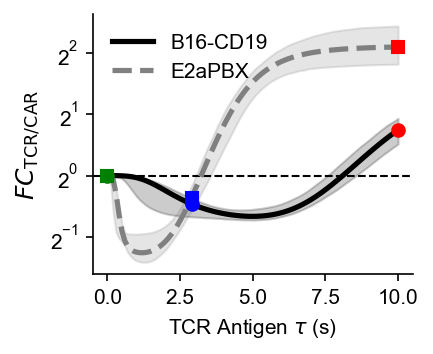

In [9]:
# Plot antagonism ratio vs tau for the L_TCR, L_CAR conditions of B16 tumors. 
fig, ax = plt.subplots()
fig.set_size_inches(2.75, 2.25)
xvals = np.sort(df_model.index.get_level_values("TCR_Antigen_tau").unique().values)
ax.axhline(1.0, ls="--", color="k", lw=1.0)

tumor_colors = {"E2aPBX":"grey", "B16-CD19":"k"}
tumor_styles = {"E2aPBX":"--", "B16-CD19":"-"}
for tumor in list(df_model.index.get_level_values("TumorLine").unique())[::-1]:  
    yvals = df_model.loc[(tumor, pulse_tcr_range[0], xvals), "best"].values
    yvals_down = df_model.loc[(tumor, pulse_tcr_range[0], xvals), "percentile_2.5"].values
    yvals_up = df_model.loc[(tumor, pulse_tcr_range[0], xvals), "percentile_97.5"].values
    ax.plot(xvals, yvals, lw=2.5, color=tumor_colors[tumor], label=tumor, 
           ls=tumor_styles[tumor])
    ax.fill_between(xvals, yvals_down, yvals_up, color=tumor_colors[tumor], alpha=0.2)

highlight_colors = ["g", "b", "r"]
highlight_labels = ["None", "V4", "N4"]
tumor_markers = {"B16-CD19":"o", "E2aPBX":"s"}
for i in range(len(highlight_taus)):
    #for tumor in df_model.index.get_level_values("TumorLine").unique():
    for tumor in ["B16-CD19", "E2aPBX"]:
        tau_tcr = highlight_taus[i]
        #lbl = highlight_labels[i] if tumor == "B16-CD19" else None
        ax.plot(tau_tcr, df_model.loc[(tumor, pulse_tcr_range[0], tau_tcr), "best"], 
                ls="none", marker=tumor_markers.get(tumor), 
                mfc=highlight_colors[i], ms=6, mec=highlight_colors[i])

ax.set_xlabel(r"TCR Antigen $\tau$ (s)")
ax.set_ylabel(ylabel=r"$FC_{\mathrm{TCR/CAR}}$", size=12)
ax.set_yscale("log", base=2)
#ax.set_ylim([0.48, 2.05])
ax.legend(frameon=False)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)

if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "antagonism_b16_surface_molecule_numbers.pdf"), 
        transparent=True, bbox_inches="tight")
plt.show()
plt.close()
# Highlight None, V4 and N4 with Green, Blue, Red?

In [10]:
# Recompute CAR and TCR only outputs
other_rates, ritot, nmf_fixed, cd19_tau_l = cost_args_loaded
res = repackage_tcr_car_params(pvec_best, chosen_kmf, *cost_args_loaded[:3])
(
all_rates, tcr_rates, car_rates, ritot_vec, tcr_ri, car_ri,
nmf_both, tcr_nmf, car_nmf, threshold_taus
) = res
# Compute thresholds
tcr_thresh = steady_akpr_i_1ligand(tcr_rates, threshold_taus[0],
        10*tcr_ri[0], tcr_ri, tcr_nmf, large_l=True)[tcr_nmf[0]]
car_thresh = steady_akpr_i_1ligand(car_rates, threshold_taus[1],
        10*car_ri[0], car_ri, car_nmf, large_l=True)[car_nmf[0]]

b16_alone = activation_function(steady_akpr_i_1ligand(
    car_rates, cd19_tau_l[0], cd19_levels_dict["B16-CD19"], 
    car_ri, car_nmf)[-2], car_thresh
)
e2a_alone = activation_function(steady_akpr_i_1ligand(
    car_rates, cd19_tau_l[0], cd19_levels_dict["E2aPBX"], 
    car_ri, car_nmf)[-2], car_thresh
)

In [11]:
fname = os.path.join(res_folder, "model_antagonism_ratio_b16_e2apbx.h5")
df_model_save = df_model
df_model_save.index = df_model_save.index.set_names([a.replace("^", "_") 
                        for a in df_model_save.index.names])
if do_save_outputs:
    df_model_save.to_hdf(fname, key="df")
    with h5py.File(fname, "a") as h:
        try:
            grp = h.create_group("ag_alone")
        except (ValueError, RuntimeError) as e:
            grp = h.get("ag_alone")
        else:
            grp["Z_C_b16"] = b16_alone
            grp["Z_C_e2apbx"] = e2a_alone
        del grp

    with open(os.path.join(res_folder, "l_tcr_b16_e2apbx.json"), "w") as h:
        json.dump(l_tcr_dict, h, indent=2)

# Figure S5: Model predictions for varying CD19 density
Predictions for the regime relevant to Nalm6 tumors with varying amounts of CD19 on their surface. For now, eyeball the data in the bar graph of figure 4. 

In [12]:
# Tumor parameters
size_factor_nalm6 = 2.5  # Taisuke: B16:10, Nalm6: 5, E2aPBX: 2

molec_counts_filename = os.path.join(surf_folder, "surface_molecule_summary_stats.h5")
molec_stats = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
mhc_levels_nalm6 = {}
cd19_levels_nalm6 = {}
tumor_order = ["CD19_High", "CD19_Med", "CD19_Low", "CD19_KO"]
tumor_names_df = ["Nalm6_19hi", "Nalm6_19int", "Nalm6_19low", "Nalm6_19KO"]
tumor_names_map = dict(zip(tumor_order, tumor_names_df))
mtc = "Geometric mean"
for tumor, lbl in tumor_names_map.items():
    mhc_levels_nalm6[tumor] = molec_stats.at[(lbl, "MHC"), mtc] / size_factor_nalm6
    cd19_levels_nalm6[tumor] = molec_stats.at[(lbl, "CD19"), mtc] / size_factor_nalm6
mhc_levels_nalm6 = geo_mean(pd.Series(mhc_levels_nalm6), axis=0)
# Try KO = 0 CD19 too for comparison

In [13]:
# The baseline signaling is the level of activity produced by 9C alone, with CD19-KO tumor
# So that's output for a TCR only , and so we need to compute that output using model parameters
# Unwrap model parameters for this purpose
other_rates, ritot, nmf_fixed, cd19_tau_l = cost_args_loaded
res = repackage_tcr_car_params(pvec_best, chosen_kmf, *cost_args_loaded[:3])
(
all_rates, tcr_rates, car_rates, ritot_vec, tcr_ri, car_ri,
nmf_both, tcr_nmf, car_nmf, threshold_taus
) = res
# Compute thresholds
tcr_thresh = steady_akpr_i_1ligand(tcr_rates, threshold_taus[0],
        10*tcr_ri[0], tcr_ri, tcr_nmf, large_l=True)[tcr_nmf[0]]
car_thresh = steady_akpr_i_1ligand(car_rates, threshold_taus[1],
        10*car_ri[0], car_ri, car_nmf, large_l=True)[car_nmf[0]]

with open("data/pep_tau_map_others.json", "r") as h:
    other_taus = json.load(h)
# 9C doesn't give activation, 9V gives some. Take a tau halfway, 
# put an error bar = 1/10 distance on this tau, to have
# an uncertainty on the true background baseline of this experiment. 
# This is the main source of uncertainty on the background, neglect
# to propagate the rest (e.g. TCR parameters) because tau_base is the core one. 
tau_base = (other_taus["NYESO-9C"] + other_taus["NYESO-9V"]) / 2.0
tau_base_std = 0.1 * abs(other_taus["NYESO-9C"] - other_taus["NYESO-9V"])
rgen_main = np.random.default_rng(0x74653a8ec8aa486b42cb85621271b401)
tau_base_samples = tau_base + tau_base_std*rgen_main.standard_normal(size=10000)
tau_base_samples = np.clip(tau_base_samples, a_min=0.01, a_max=np.inf)
baseline_out_samples = np.zeros(tau_base_samples.size)
for i in range(baseline_out_samples.size):
    baseline_out_samples[i] = activation_function(steady_akpr_i_1ligand(
        tcr_rates, tau_base_samples[i], mhc_levels_nalm6, tcr_ri, tcr_nmf)[-2], tcr_thresh)

# Best estimate and log-scale standard deviation of this background
# based on our uncertainty on the threshold tau in between 9C and 9V. 
baseline_out = geo_mean(baseline_out_samples, axis=0)
baseline_out_logstd = np.std(np.log10(baseline_out_samples))

# Moreover, divide the CAR threshold by 20 to account for strong CAR signal in PLCgamma
scale_car_threshold = 1.0 / 20.0
scale_car_threshold_logstd = 0.1  # in log10 scale, unsure about this factor

# Also, default receptor numbers and their uncertainties. 
molec_loads = load_tcr_car_molec_numbers_ci(
    molec_counts_filename, mtc, tumor_type="E2aPBX_WT", tcell_type="OT1_CAR", 
    tumor_antigen="CD19", data_fold="data/"
)
all_stds, all_ndofs = molec_loads[5], molec_loads[6]
ritot_defaults = cost_args_loaded[1]
ritot_default_stds_dofs = [all_stds[:2], all_ndofs[:2]] # TCR, CAR numbers are first two entries

In [14]:
# Try with confidence intervals now, using dedicated functions
# Define panel arguments and prediction function arguments
tau_tcr_range = np.linspace(0.001, 4.0, 101)
pulse_tcr_range = np.ones(1) * 1.0  # pulse concentrations in uM; here, saturating conc.
cond_nalm6_index = pd.MultiIndex.from_product([pulse_tcr_range, tau_tcr_range], 
                names=["TCR_Antigen_Pulse_uM", "TCR_Antigen_tau"]
)
# cost_args_loaded: other_rates, ritot, nmf_fixed, cd19_tau_l
panel_args = list(cost_args_loaded) + [baseline_out, scale_car_threshold, ritot_defaults]

seedlist = np.random.SeedSequence(0x2f75e0952d1e38d62224bc267574c987).spawn(len(cd19_levels_nalm6))
df_model = {}
for i, t in enumerate(cd19_levels_nalm6.keys()):
    print("Tumor line:", t)
    # Tumor line specific info, TCR and CAR numbers stay the same
    tumor_line_info = {
        "l_conc_mm_params":[mhc_levels_nalm6, l_conc_mm_params[1]], 
        "car_ag":cd19_levels_nalm6[t]
    }
    # Uncertainty on the TCR, CAR, CAR Ag, MHC, loading EC50
    molec_loads = load_tcr_car_molec_numbers_ci(
        molec_counts_filename, mtc, tumor_type=tumor_names_map[t], tcell_type="OT1_CAR", 
        tumor_antigen="CD19", data_fold="data/"
    )
    all_stds, all_ndofs = molec_loads[5], molec_loads[6]
    df_model[t] = confidence_predictions_car_antagonism(
        antag_ratio_panel_tcr_car_numbers, 
        mcmc_samples_car,
        pvec_best,
        chosen_kmf,
        cond_nalm6_index, 
        analysis_fct=compute_stats_ci,
        other_args=panel_args,
        seed=seedlist[i], 
        n_samp=n_boot, 
        antagonist_lvl=cond_nalm6_index.names[1],
        tcr_pulse_lvl=cond_nalm6_index.names[0],
        cell_info=tumor_line_info, 
        molec_stds=all_stds, 
        molec_dofs=all_ndofs, 
        baseline_std=baseline_out_logstd,
        scale_car_thresh_std=scale_car_threshold_logstd,
        ritot_default_stds_dofs=ritot_default_stds_dofs
    )
    print()
df_model = pd.concat(df_model, names=["Tumor"], axis=0)
df_model

Tumor line: CD19_High
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)

Tumor line: CD19_Med
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)

Tumor line: CD19_Low
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)

Tumor line: CD19_KO
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)



percentile_2.5    median  \
Tumor     TCR_Antigen_Pulse_uM TCR_Antigen_tau                             
CD19_High 1.0                  0.00100                1.000000  1.000000   
                               0.04099                0.999994  1.000000   
                               0.08098                0.999891  0.999992   
                               0.12097                0.999485  0.999958   
                               0.16096                0.998755  0.999868   
...                                                        ...       ...   
CD19_KO   1.0                  3.84004                1.559747  2.616182   
                               3.88003                1.586114  2.677290   
                               3.92002                1.613161  2.741565   
                               3.96001                1.640801  2.803273   
                               4.00000                1.667927  2.867974   

                                                    mean  geo_mean      best  \
Tumor     TCR_Antigen_Pulse_uM TCR_Antigen_tau                                 
CD19_High 1.0                  0.00100          1.000000  1.000000  1.000000   
                               0.04099          0.999999  0.999999  1.000000   
                               0.08098          0.999979  0.999979  0.999995   
                               0.12097          0.999893  0.999893  0.999974   
                               0.16096          0.999714  0.999714  0.999915   
...                                                  ...       ...       ...   
CD19_KO   1.0                  3.84004          2.880365  2.725640  2.773669   
                               3.88003          2.951714  2.790207  2.839472   
                               3.92002          3.023533  2.855224  2.905553   
                               3.96001          3.095707  2.920586  2.971795   
                               4.00000          3.168118  2.986190  3.038084   

                                                percentile_97.5  
Tumor     TCR_Antigen_Pulse_uM TCR_Antigen_tau                   
CD19_High 1.0                  0.00100                 1.000000  
                               0.04099                 1.000000  
                               0.08098                 0.999998  
                               0.12097                 0.999990  
                               0.16096                 0.999969  
...                                                         ...  
CD19_KO   1.0                  3.84004                 5.579906  
                               3.88003                 5.720733  
                               3.92002                 5.860460  
                               3.96001                 5.999074  
                               4.00000                 6.161398  

[404 rows x 6 columns]

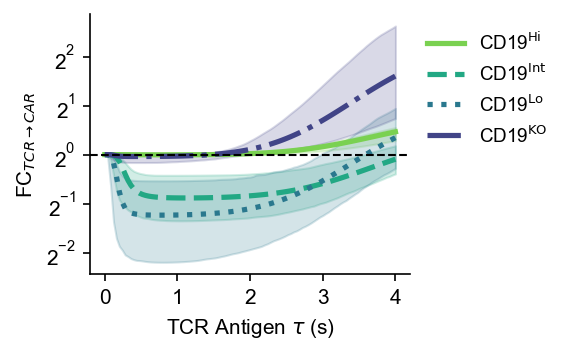

In [15]:
# Plot antagonism ratio vs tau for the L_TCR, L_CAR conditions of B16 tumors. 
# Color palette for the tumors: mako
tumor_colors = sns.color_palette("viridis_r", n_colors=len(cd19_levels_nalm6))
tumor_colors = {t:tumor_colors[i] for i, t in enumerate(tumor_order)}

fig, ax = plt.subplots()
fig.set_size_inches(2.75, 2.25)
xvals = np.sort(df_model.index.get_level_values("TCR_Antigen_tau").unique().values)

tumor_styles = ["-", "--", ":", "-."]
tumor_styles = {t:tumor_styles[i] for i, t in enumerate(tumor_order)}

nice_tumor_lbls = {
    "CD19_High":r"CD19${}^{\mathrm{Hi}}$", 
    "CD19_Med":r"CD19${}^{\mathrm{Int}}$", 
    "CD19_Low":r"CD19${}^{\mathrm{Lo}}$",
    "CD19_KO":r"CD19${}^{\mathrm{KO}}$",
}

for tumor in df_model.index.get_level_values("Tumor").unique():  
    yvals = df_model.loc[(tumor, 1.0, xvals), "best"].values
    ax.plot(xvals, yvals, lw=2.5, color=tumor_colors[tumor], label=nice_tumor_lbls[tumor], 
           ls=tumor_styles[tumor])
    yvals_down = df_model.loc[(tumor, 1.0, xvals), "percentile_2.5"].values
    yvals_up = df_model.loc[(tumor, 1.0, xvals), "percentile_97.5"].values
    ax.fill_between(xvals, yvals_down, yvals_up, color=tumor_colors[tumor], alpha=0.2)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
ax.set(ylabel=r"FC${}_{TCR \rightarrow CAR}$", 
        xlabel=r"TCR Antigen $\tau$ (s)")
ax.set_yscale("log", base=2)
#ax.set_ylim([0.48, 2.05])
ax.legend(fontsize=9, frameon=False, loc="upper left", bbox_to_anchor=(1.0, 1.0))
ax.axhline(1.0, ls="--", color="k", lw=1.0)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "antagonism_nalm6_varying_cd19_levels.pdf"), transparent=True, 
            bbox_inches="tight")
plt.show()
plt.close()

In [16]:
fname = os.path.join(res_folder, "model_antagonism_varying_cd19_human_cells.h5")
df_model_save = df_model.copy()
if do_save_outputs:
    df_model_save.to_hdf(fname, key="df")
    with h5py.File(fname, "a") as h:
        try:
            grp = h.create_group("cd19_levels")
        except (ValueError, RuntimeError) as e:
            grp = h.get("cd19_levels")
        else:
            dict_to_hdf5(grp, cd19_levels_nalm6)

        try:
            grp = h.create_group("mhc_levels")
        except (ValueError, RuntimeError) as e:
            grp = h.get("mhc_levels")
        else:
            grp["mhc_level"] = mhc_levels_nalm6

# Figure 6: Model predictions for AEBS CAR-T cells
APCs change, and also their respective TCR antigen. 

Healthy tissue, BEAS2B-GL lung cell line: 
 - Peptide: HHAT-WT
 - HLA-A2 level: a little over $10^6$
 - Her2 level: $2 \times 10^4$
 
Tumor cells, PC9-GL:
 - Peptide: HHAT-p8F
 - HLA-A2 level: $7 \times 10^4$
 - Her2 level: $4 \times 10^4$
 
Treat Her2-CAR affinity like CD19-CAR affinity to begin with, adjust if necessary. 

In [17]:
df_her = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
# The experiment only used BEAS2B_GL and PC9_GL
df_her = df_her.loc[df_her.index.isin(["BEAS2B", "PC9"], level="Cell")]
df_her = (df_her.rename({"BEAS2B":"BEAS2B_GL", "PC9":"PC9_GL"}, level="Cell", axis=0)
            .rename({"MHC":"HLA_A2"}, level="Marker", axis=0))
df_her

Mean  Geometric mean  Percentile 2.5  \
Cell      Marker                                                 
BEAS2B_GL Her2    1.932132e+04    1.705127e+04    5.415144e+03   
          HLA_A2  3.015071e+06    3.007904e+06    3.021412e+06   
PC9_GL    Her2    3.664064e+04    3.329423e+04    1.290866e+04   
          HLA_A2  8.737303e+05    7.377525e+05    1.762071e+05   

                  Percentile 97.5        Median  Standard deviation  \
Cell      Marker                                                      
BEAS2B_GL Her2       4.199202e+04  1.768514e+04         9454.917614   
          HLA_A2     3.021412e+06  3.021412e+06       101115.467830   
PC9_GL    Her2       7.255239e+04  3.446743e+04        16344.865229   
          HLA_A2     2.089305e+06  7.909687e+05       493585.009025   

                  Stdev log10   dof  Mean CI 0.025  Mean CI 0.975  \
Cell      Marker                                                    
BEAS2B_GL Her2       0.228189  7851   1.910054e+04   1.956321e+04   
          HLA_A2     0.046502  5474   3.011902e+06   3.017744e+06   
PC9_GL    Her2       0.195274  5168   3.612405e+04   3.715304e+04   
          HLA_A2     0.269664  6285   8.614873e+05   8.871999e+05   

                  Geometric mean CI 0.025  Geometric mean CI 0.975  
Cell      Marker                                                    
BEAS2B_GL Her2               1.683051e+04             1.725747e+04  
          HLA_A2             2.997209e+06             3.015981e+06  
PC9_GL    Her2               3.277244e+04             3.373842e+04  
          HLA_A2             7.257639e+05             7.502343e+05

In [18]:
# Data on L_T, L_C for both APC lines
size_factor_her = 1.0  # Unsure of the size, don't correct because qualitative anyways
mtc = "Geometric mean"
hla_levels = {
    "BEAS2B-GL": df_her.loc[("BEAS2B_GL", "HLA_A2"), mtc] / size_factor_her,
    "PC9-GL": df_her.loc[("PC9_GL", "HLA_A2"), mtc] / size_factor_her
}

her2_levels = {
    "BEAS2B-GL": df_her.loc[("BEAS2B_GL", "Her2"), mtc] / size_factor_her,
    "PC9-GL": df_her.loc[("PC9_GL", "Her2"), mtc] / size_factor_her
}

# Also uncertainties on these ligand and receptor numbers
her2_molec_stds_dofs = {}
tum_names_map = {"BEAS2B-GL":"BEAS2B", "PC9-GL":"PC9"}
for tum in hla_levels.keys():
    her2_molec_stds_dofs[tum] = load_tcr_car_molec_numbers_ci(
        molec_counts_filename, mtc, tumor_type=tum_names_map[tum], 
        tcell_type="OT1_CAR", tumor_antigen="Her2", data_fold="data/", 
        mhc_name="MHC"
    )[5:]  # 5 is stds, 6 is n_dofs

# High affinity ligand for the CAR, assume it is just like CD19.  
her2_tau = cd19_tau_l[0]

# Based on CD25 dose response EC50 conversion, tau for the two peptides
with open("data/pep_tau_map_others.json", "r") as h:
    other_taus = json.load(h)
hhat_pep_taus = {
    "HHAT-WT": other_taus.get("HHAT-WT"), 
    "HHAT-p8F": other_taus.get("HHAT-p8F")
}

# Which tumor has which peptide
tumor_peptide_map = {
    "BEAS2B-GL": "HHAT-WT", 
    "PC9-GL": "HHAT-p8F"
}

In [19]:
tau_tcr_range = list(np.linspace(0.001, 10.0, 201))
tau_tcr_range.append(hhat_pep_taus["HHAT-WT"])
tau_tcr_range.append(hhat_pep_taus["HHAT-p8F"])

# We assume all MHC are filled, use high pulse concentration
pulse_conc_range = np.ones(1) * 1e0  # in uM
cond_aebs_index = pd.MultiIndex.from_product(
    [pulse_conc_range, tau_tcr_range], names=["TCR_Antigen_Pulse_uM", "TCR_Antigen_tau"])

# cost_args_loaded: other_rates, ritot, nmf_fixed, cd19_tau_l
panel_args = list(cost_args_loaded)
# Avoid side effect on the original cost_args_loaded
panel_args[3] = (her2_tau, panel_args[3][1])

seedlist = np.random.SeedSequence(0x5212c31b07fa1d81b56917c89e5c5cfa).spawn(len(hla_levels))
df_model_aebs = {}
for i, t in enumerate(hla_levels.keys()):
    print("Tumor line:", t)
    tumor_line_info = {
        "l_conc_mm_params": [hla_levels[t], l_conc_mm_params[1]], 
        "car_ag":her2_levels[t]
    }
    df_model_aebs[t] = confidence_predictions_car_antagonism(
        antag_ratio_panel_tcr_car, 
        mcmc_samples_car,
        pvec_best,
        chosen_kmf,
        cond_aebs_index, 
        analysis_fct=compute_stats_ci,
        other_args=panel_args,
        seed=seedlist[i],
        n_samp=n_boot,
        antagonist_lvl=cond_aebs_index.names[1],
        tcr_pulse_lvl=cond_aebs_index.names[0],
        cell_info=tumor_line_info, 
        molec_stds=her2_molec_stds_dofs[t][0],
        molec_dofs=her2_molec_stds_dofs[t][1],
    )
    print()
df_model_aebs = pd.concat(df_model_aebs, names=["Target"], axis=0)
df_model_aebs

Tumor line: BEAS2B-GL
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)

Tumor line: PC9-GL
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)



percentile_2.5     median  \
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                              
BEAS2B-GL 1.0                  0.001000               1.000000   1.000000   
                               0.050995               0.839430   0.988708   
                               0.100990               0.283864   0.849862   
                               0.150985               0.136864   0.539264   
                               0.200980               0.108448   0.293838   
...                                                        ...        ...   
PC9-GL    1.0                  9.800020               9.022859  12.462860   
                               9.850015               9.024069  12.464986   
                               9.900010               9.025236  12.467035   
                               9.950005               9.026361  12.469012   
                               10.000000              9.027447  12.470919   

                                                     mean   geo_mean  \
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                         
BEAS2B-GL 1.0                  0.001000          1.000000   1.000000   
                               0.050995          0.966898   0.965835   
                               0.100990          0.746965   0.707843   
                               0.150985          0.482212   0.422769   
                               0.200980          0.289333   0.255757   
...                                                   ...        ...   
PC9-GL    1.0                  9.800020         13.417172  12.487408   
                               9.850015         13.443097  12.489925   
                               9.900010         13.469465  12.492363   
                               9.950005         13.496286  12.494725   
                               10.000000        13.523568  12.497015   

                                                     best  percentile_97.5  
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                              
BEAS2B-GL 1.0                  0.001000          1.000000         1.000000  
                               0.050995          0.993194         0.996296  
                               0.100990          0.903998         0.945534  
                               0.150985          0.656849         0.777921  
                               0.200980          0.390284         0.531032  
...                                                   ...              ...  
PC9-GL    1.0                  9.800020         12.156999        17.937632  
                               9.850015         12.158700        17.942244  
                               9.900010         12.160341        17.946224  
                               9.950005         12.161923        17.950064  
                               10.000000        12.163450        17.953768  

[406 rows x 6 columns]

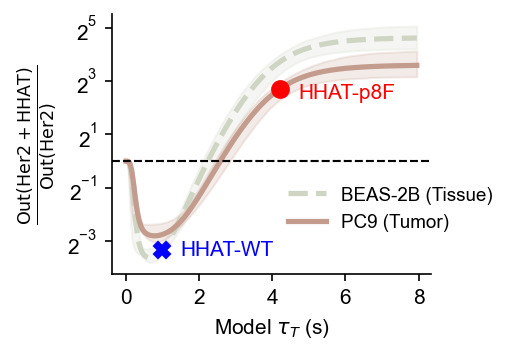

In [20]:
# Plot results: just two antagonism ratio curves vs tau, highlight the peptides
# Aesthetic parameters
tumor_palette = {
    "BEAS2B-GL": "#CED5C3",  # pale green from fig. 5
    #"BEAS2B-GL": (167/255, 177/255, 112/255), # Slightly darker green (nucleus in fig. 5)
    #"PC9-GL": "#DFBCA8",  # pale pink from fig. 5
    "PC9-GL": (195/255, 156/255, 142/255),   # Slightly darker pink (nucleus in fig. 5)
}
peptide_palette = {
    "HHAT-WT": "b", 
    "HHAT-p8F": "r"
}
markerstyles = {
    "BEAS2B-GL":"X", 
    "PC9-GL": "o"
}
linestyles = {
    "BEAS2B-GL": "--", 
    "PC9-GL": "-"
}

fig, ax = plt.subplots()
fig.set_size_inches(2.75, 2.25)

peptide_labels = {
    "BEAS2B-GL": r"HHAT${}^{p8F}$ (Neoantigen)", 
    "PC9-GL": r"HHAT${}^{WT}$ (Self-antigen)", 
}
# Nicer name for tumors
tumor_labels = {
    "BEAS2B-GL": "BEAS-2B (Tissue)", 
    "PC9-GL": "PC9 (Tumor)"
}

ax.axhline(1.0, ls=":", lw=1.0, color="k")
for tumor in tumor_palette:
    # Best fit curve
    xvals = np.sort(df_model_aebs.xs(tumor, level="Target").index
            .get_level_values("TCR_Antigen_tau").unique().values)
    xvals = xvals[xvals <= 8.0]
    yvals = df_model_aebs.loc[(tumor, slice(None), xvals), "best"].values
    ax.plot(xvals, yvals, label=tumor_labels[tumor], color=tumor_palette[tumor], 
           ls=linestyles[tumor], alpha=1, lw=2.5)
    # confidence interval
    yvals_down = df_model_aebs.loc[(tumor, slice(None), xvals), "percentile_2.5"].values
    yvals_up = df_model_aebs.loc[(tumor, slice(None), xvals), "percentile_97.5"].values
    ax.fill_between(xvals, yvals_down, yvals_up, color=tumor_palette[tumor], alpha=0.2)
    # highlight
    tau_mark = hhat_pep_taus[tumor_peptide_map[tumor]]
    mark_color = peptide_palette[tumor_peptide_map[tumor]]
    ymark = df_model_aebs.loc[(tumor, slice(None), tau_mark), "best"].values
    yfact = 0.9 if tumor == "PC9-GL" else 1.0
    ax.plot([tau_mark], ymark, 
           ls="none", marker=markerstyles[tumor], mfc=mark_color, mec=mark_color, ms=8)
    ax.annotate(tumor_peptide_map[tumor], xy=(tau_mark+0.5, ymark*yfact), fontsize=10, 
                ha="left", va="center", color=mark_color)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
ax.set_xlabel(r"Model $\tau_T$ (s)")
ax.set_ylabel(r"$\frac{\mathrm{Out(Her2 + HHAT)}}{\mathrm{Out(Her2)}}$", size=12)
ax.set_yscale("log", base=2)
#ax.set_ylim([0.48, 2.05])
ax.legend(fontsize=9, frameon=False, loc="lower left", bbox_to_anchor=(0.5, 0.1))
ax.axhline(1.0, ls="--", color="k", lw=1.0)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "antagonism_hhat_peptides_beas2b_pc9_numbers.pdf"), transparent=True, 
            bbox_inches="tight")
plt.show()
plt.close()

In [21]:
df_model_aebs

percentile_2.5     median  \
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                              
BEAS2B-GL 1.0                  0.001000               1.000000   1.000000   
                               0.050995               0.839430   0.988708   
                               0.100990               0.283864   0.849862   
                               0.150985               0.136864   0.539264   
                               0.200980               0.108448   0.293838   
...                                                        ...        ...   
PC9-GL    1.0                  9.800020               9.022859  12.462860   
                               9.850015               9.024069  12.464986   
                               9.900010               9.025236  12.467035   
                               9.950005               9.026361  12.469012   
                               10.000000              9.027447  12.470919   

                                                     mean   geo_mean  \
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                         
BEAS2B-GL 1.0                  0.001000          1.000000   1.000000   
                               0.050995          0.966898   0.965835   
                               0.100990          0.746965   0.707843   
                               0.150985          0.482212   0.422769   
                               0.200980          0.289333   0.255757   
...                                                   ...        ...   
PC9-GL    1.0                  9.800020         13.417172  12.487408   
                               9.850015         13.443097  12.489925   
                               9.900010         13.469465  12.492363   
                               9.950005         13.496286  12.494725   
                               10.000000        13.523568  12.497015   

                                                     best  percentile_97.5  
Target    TCR_Antigen_Pulse_uM TCR_Antigen_tau                              
BEAS2B-GL 1.0                  0.001000          1.000000         1.000000  
                               0.050995          0.993194         0.996296  
                               0.100990          0.903998         0.945534  
                               0.150985          0.656849         0.777921  
                               0.200980          0.390284         0.531032  
...                                                   ...              ...  
PC9-GL    1.0                  9.800020         12.156999        17.937632  
                               9.850015         12.158700        17.942244  
                               9.900010         12.160341        17.946224  
                               9.950005         12.161923        17.950064  
                               10.000000        12.163450        17.953768  

[406 rows x 6 columns]

In [22]:
fname = os.path.join(res_folder, "model_predict_aebs_hhat_wt_neoantigen.h5")
df_model_save = df_model_aebs.copy()
if do_save_outputs:
    df_model_save.to_hdf(fname, key="df")

    # Save all HHAT peptide parameters in a JSON file
    hhat_params_dict = {
        "hla_levels": hla_levels, 
        "her2_levels": her2_levels, 
        "hhat_pep_taus": hhat_pep_taus, 
        "tumor_peptide_map": tumor_peptide_map,
        "her2_tau": her2_tau, 

    }
    fname = os.path.join(res_folder, "hhat_peptides_params_aebs_wt_neoantigen.json")
    with open(fname, "w") as h:
        json.dump(hhat_params_dict, h, indent=2)

# Figure S3: CD4 SMARTA CAR T cells, B6 splenocytes for MHC-II

In [23]:
# For OT-1 CAR T cell comparison, we already have the CIs
ci_file_ot1 = os.path.join(res_folder, "dfs_model_data_ci_mcmc_both_conc.h5")
df_model_ot1 = (pd.read_hdf(ci_file_ot1, key="model")
                 .sort_index().loc[("10", "3", str(chosen_kmf)), :].xs("Fit", level="Subset")
               .droplevel("TCR_Antigen_EC50")
               )

df_model_ot1.index =  df_model_ot1.index.rename(
    {"TCR_Antigen_Density":"TCR_Antigen_Pulse_uM", "TCR_Antigen":"TCR_Antigen_tau"})
df_model_ot1

percentile_2.5    median      mean  \
TCR_Antigen_Pulse_uM TCR_Antigen_tau                                       
1nM                  0.001000               1.000000  1.000000  1.000000   
                     0.051246               0.999970  0.999998  0.999994   
                     0.101492               0.999360  0.999952  0.999864   
                     0.151739               0.996373  0.999729  0.999229   
                     0.201985               0.988075  0.999094  0.997450   
...                                              ...       ...       ...   
1uM                  9.799015               3.481258  4.311204  4.344643   
                     9.849261               3.482194  4.312837  4.346629   
                     9.899508               3.483100  4.314324  4.348550   
                     9.949754               3.483975  4.315762  4.350409   
                     10.000000              3.484823  4.317168  4.352209   

                                      geo_mean      best  percentile_97.5  
TCR_Antigen_Pulse_uM TCR_Antigen_tau                                       
1nM                  0.001000         1.000000  1.000000         1.000000  
                     0.051246         0.999994  0.999999         0.999999  
                     0.101492         0.999864  0.999971         0.999983  
                     0.151739         0.999229  0.999836         0.999900  
                     0.201985         0.997444  0.999451         0.999667  
...                                        ...       ...              ...  
1uM                  9.799015         4.314247  4.247642         5.353770  
                     9.849261         4.316170  4.249218         5.358275  
                     9.899508         4.318031  4.250743         5.362588  
                     9.949754         4.319833  4.252218         5.366078  
                     10.000000        4.321576  4.253646         5.368503  

[400 rows x 6 columns]

In [24]:
# Load all CAR and TCR antigen numbers on the tumor line used for SMARTA CARs
molec_counts_filename = os.path.join(surf_folder, "surface_molecule_summary_stats.h5")
mtc = "Geometric mean"
cell_line = "B6"
molec_stats = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
mhc1_levels_b6 = molec_stats.loc[(cell_line, "MHC"), mtc]
mhc2_levels_b6 = 62514
cd19_levels_b6 = 78824

# Uncertainty on ligand levels
molec_stds_b6, molec_dofs_b6 = load_tcr_car_molec_numbers_ci(
        molec_counts_filename, mtc, tumor_type="B6", 
        tcell_type="OT1_CAR", tumor_antigen="CD19", data_fold="data/", 
        mhc_name="MHC")[5:]

In [25]:
# Run simulations
tau_tcr_range_cd4 = list(np.linspace(0.001, 10.0, 201))

# We assume all MHC are filled, use high pulse concentration
pulse_conc_range = np.ones(1) * 1e0  # in uM
cond_cd4_index = pd.MultiIndex.from_product(
    [pulse_conc_range, tau_tcr_range_cd4], names=["TCR_Antigen_Pulse_uM", "TCR_Antigen_tau"])

# cost_args_loaded: other_rates, ritot, nmf_fixed, cd19_tau_l
panel_args = list(cost_args_loaded)

seed_cd4 = np.random.SeedSequence(0x91a7fb9c68a3bbd4f08e5fe3dca134ef)
b6_line_info = {
    "l_conc_mm_params": [mhc2_levels_b6, l_conc_mm_params[1]], 
    "car_ag": cd19_levels_b6
}
df_model_cd4 = confidence_predictions_car_antagonism(
    antag_ratio_panel_tcr_car, 
    mcmc_samples_car,
    pvec_best,
    chosen_kmf,
    cond_cd4_index, 
    analysis_fct=compute_stats_ci,
    other_args=panel_args,
    seed=seed_cd4,
    n_samp=n_boot,
    antagonist_lvl=cond_cd4_index.names[1],
    tcr_pulse_lvl=cond_cd4_index.names[0],
    cell_info=b6_line_info, 
    molec_stds=molec_stds_b6,
    molec_dofs=molec_dofs_b6,
)
df_model_cd4

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)


percentile_2.5    median      mean  \
TCR_Antigen_Pulse_uM TCR_Antigen_tau                                       
1.0                  0.001000               1.000000  1.000000  1.000000   
                     0.050995               0.995140  0.999660  0.998924   
                     0.100990               0.910906  0.992859  0.979025   
                     0.150985               0.696721  0.961182  0.911028   
                     0.200980               0.531135  0.884950  0.810893   
...                                              ...       ...       ...   
                     9.800020               4.342345  5.534291  5.622754   
                     9.850015               4.343976  5.536564  5.626152   
                     9.900010               4.345554  5.538762  5.629484   
                     9.950005               4.347080  5.540889  5.632755   
                     10.000000              4.348557  5.542947  5.635966   

                                      geo_mean      best  percentile_97.5  
TCR_Antigen_Pulse_uM TCR_Antigen_tau                                       
1.0                  0.001000         1.000000  1.000000         1.000000  
                     0.050995         0.998923  0.999794         0.999873  
                     0.100990         0.978689  0.995658         0.997313  
                     0.150985         0.906328  0.975886         0.984907  
                     0.200980         0.797491  0.924929         0.951608  
...                                        ...       ...              ...  
                     9.800020         5.560609  5.448258         7.279542  
                     9.850015         5.563262  5.450210         7.283544  
                     9.900010         5.565837  5.452098         7.287417  
                     9.950005         5.568335  5.453924         7.291164  
                     10.000000        5.570759  5.455692         7.294791  

[201 rows x 6 columns]

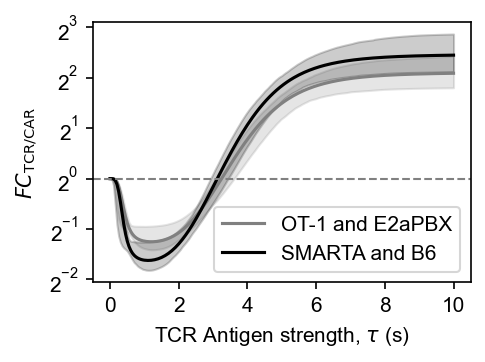

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(3.25, 2.25)
tau_tcr_range_ot1 = np.sort(df_model_ot1.index.get_level_values("TCR_Antigen_tau").unique())
ax.plot(tau_tcr_range_ot1, df_model_ot1.loc[("1uM", tau_tcr_range_ot1), "best"], 
        color="grey", label="OT-1 and E2aPBX")
ax.fill_between(tau_tcr_range_ot1, df_model_ot1.loc[("1uM", tau_tcr_range_ot1), "percentile_2.5"], 
    df_model_ot1.loc[("1uM", tau_tcr_range_ot1), "percentile_97.5"],color="grey", alpha=0.2)

ax.plot(tau_tcr_range_cd4, df_model_cd4.loc[(1.0, tau_tcr_range_cd4), "best"], 
        color="k", label="SMARTA and B6")
ax.fill_between(tau_tcr_range_cd4, df_model_cd4.loc[(1.0, tau_tcr_range_cd4), "percentile_2.5"], 
    df_model_cd4.loc[(1.0, tau_tcr_range_cd4), "percentile_97.5"],color="k", alpha=0.2)

ax.set(xlabel=r"TCR Antigen strength, $\tau$ (s)", ylabel=r"$FC_{\mathrm{TCR/CAR}}$")
ax.axhline(1.0, ls="--", color="grey", lw=1.0)
ax.set_yscale("log", base=2)
ax.legend()
plt.show()
plt.close()

In [29]:
# Save
if do_save_outputs:
    hdf_filename = os.path.join(res_folder, "model_curves_cd4.h5")
    df_model_cd4.to_hdf(hdf_filename, key="SMARTA_B6")
    df_model_ot1.xs("1uM", level="TCR_Antigen_Pulse_uM", drop_level=False).to_hdf(hdf_filename, key="OT1_E2aPBX")
print(df_model_cd4)
print(df_model_ot1.xs("1uM", level="TCR_Antigen_Pulse_uM", drop_level=False))

                                      percentile_2.5    median      mean  \
TCR_Antigen_Pulse_uM TCR_Antigen_tau                                       
1.0                  0.001000               1.000000  1.000000  1.000000   
                     0.050995               0.995140  0.999660  0.998924   
                     0.100990               0.910906  0.992859  0.979025   
                     0.150985               0.696721  0.961182  0.911028   
                     0.200980               0.531135  0.884950  0.810893   
...                                              ...       ...       ...   
                     9.800020               4.342345  5.534291  5.622754   
                     9.850015               4.343976  5.536564  5.626152   
                     9.900010               4.345554  5.538762  5.629484   
                     9.950005               4.347080  5.540889  5.632755   
                     10.000000              4.348557  5.542947  5.635966   

           